In [4]:
import torch
import numpy as np
import pandas as pd
from torchvision import transforms, datasets
from tqdm import tqdm

from tsne import tsne
from networks.resnet_big import SupConResNet

In [5]:
# cifar10
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

normalize = transforms.Normalize(mean=mean, std=std)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

train_dataset = datasets.CIFAR10(root="./datasets/",
                                    transform=val_transform,
                                    download=True)
val_dataset = datasets.CIFAR10(root="./datasets/",
                                train=False,
                                transform=val_transform)

train_sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=252, shuffle=(train_sampler is None),
    num_workers=16, pin_memory=True, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=256, shuffle=False,
    num_workers=8, pin_memory=True)

Files already downloaded and verified


In [6]:
cuda_device = 1

model = SupConResNet(name="resnet50")


ckpt = torch.load("./save/SupCon/cifar10_models/SupCon_cifar10_resnet50_lr_0.5_decay_0.0001_bsz_400_temp_0.1_trial_0_cosine_warm/ckpt_epoch_300.pth", map_location='cpu')
state_dict = ckpt['model']

new_state_dict = {}
for k, v in state_dict.items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
state_dict = new_state_dict


model = model.cuda(device=cuda_device)

model.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
embedding = np.array([])
class_labels = np.array([], dtype=int)

model.eval()

for idx, (images, labels) in enumerate(tqdm(train_loader)):
    
    images = images.cuda(device=cuda_device, non_blocking=True)

    with torch.no_grad():
        features = model.encoder(images)

    embedding = np.append(embedding, features.cpu().numpy().reshape(-1, 2048))
    class_labels = np.append(class_labels, labels.numpy())
    
    if idx == 5:
        break

embedding = embedding.reshape(-1, 2048)

  0%|          | 0/199 [00:00<?, ?it/s]

  3%|▎         | 5/199 [00:05<03:20,  1.03s/it]


In [16]:
tsne_embedding = tsne(embedding, no_dims=2, initial_dims=50, perplexity=30.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1512...
Computing P-values for point 500 of 1512...
Computing P-values for point 1000 of 1512...
Computing P-values for point 1500 of 1512...
Mean value of sigma: 0.665156
Iteration 10: error is 18.441657
Iteration 20: error is 14.579969
Iteration 30: error is 12.299641
Iteration 40: error is 11.514076
Iteration 50: error is 11.281844
Iteration 60: error is 11.145886
Iteration 70: error is 11.042003
Iteration 80: error is 10.948548
Iteration 90: error is 10.878576
Iteration 100: error is 10.822962
Iteration 110: error is 1.009711
Iteration 120: error is 0.937447
Iteration 130: error is 0.868088
Iteration 140: error is 0.811275
Iteration 150: error is 0.760348
Iteration 160: error is 0.715886
Iteration 170: error is 0.678385
Iteration 180: error is 0.647292
Iteration 190: error is 0.621901
Iteration 200: error is 0.601053
Iteration 210: error is 0.583581
Iteration 220: error is 0.568698

<Axes: xlabel='x', ylabel='y'>

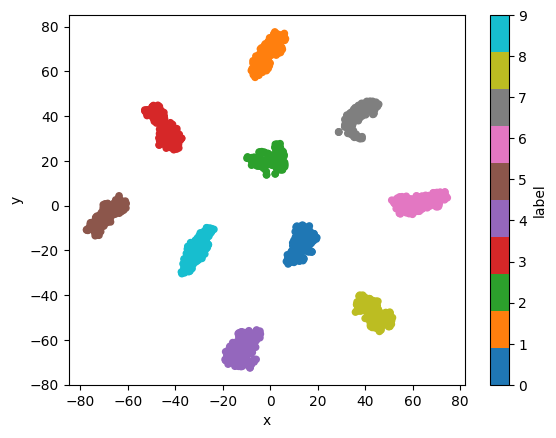

In [22]:
df = pd.DataFrame.from_dict({'x': tsne_embedding[:,0], 'y': tsne_embedding[:,1], 'label': class_labels})
df.plot.scatter(x='x', y='y', c='label', colormap='tab10')